In [1]:
from wrapped.utils import to_vis
import rasterio
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import sys
sys.path.append('./satclip')
from satclip.load import get_satclip
from huggingface_hub import hf_hub_download
import torch
from sklearn.metrics.pairwise import cosine_similarity
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from math import radians, sin, cos, acos
import pandas as pd

D:\PyCharm 2024.2.1\Projects\pythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_tif(path):
    with rasterio.open(path) as src:
        arr = src.read()
    img = torch.from_numpy(arr).float()
    return img

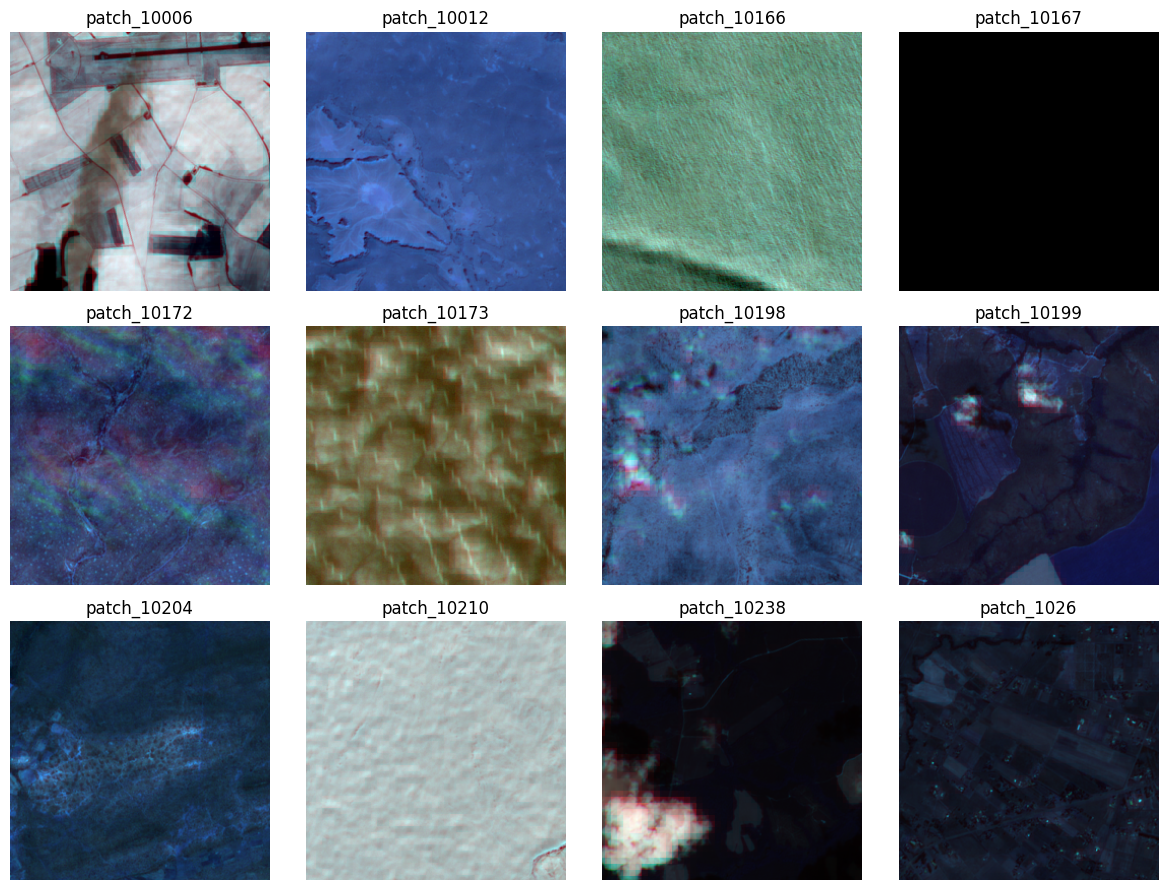

In [3]:
folder = Path("./satclip/data_10.tar/data_10/")
files = sorted(folder.glob("*.tif"))

rows, cols = 3, 4
per_page = rows * cols

for start in range(0, len(files), per_page):
    batch = files[start:start + per_page]

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.ravel()

    for ax, f in zip(axes, batch):
        img = load_tif(f)
        vis = to_vis(img)
        ax.imshow(vis)
        ax.set_title(f.stem)
        ax.axis("off")

    for ax in axes[len(batch):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    
    break

In [4]:
root = Path.cwd()
meta_csv = root / 'satclip/index.csv'  
selected_idx_csv = root / 'satclip/Selected.csv'


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ResNet50-L40", "satclip-resnet50-l40.ckpt"),
    return_all=True,
    device=device,
)
model.eval()

using pretrained moco resnet50


SatCLIP(
  (visual): ResNet(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [6]:
def get_example_image(path, plot=True):
    """
    Loads example Sentinel-2 image from path to tif file
    :param path: Path to image file
    :param plot: If True, will plot an RGB image of the satellite image
    :return: Normalized image as torch tensor
    """
    with rasterio.open(path) as f:
            data = f.read().astype(np.float32)
            image = data / 10000.0
            B10 = np.zeros((1, *image.shape[1:]), dtype=image.dtype)
            image = np.concatenate([image[:10], B10, image[10:]], axis=0)
            image = torch.tensor(image)

            if plot:
                    # Read the first three RGB bands (assuming they are bands 4, 3, and 2)
                    red_band = f.read(4) / 10000.0
                    green_band = f.read(3) / 10000.0
                    blue_band = f.read(2) / 10000.0

                    # Stack the bands to create an RGB image
                    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

                    # Plot the RGB image
                    plt.imshow(rgb_image)
                    plt.title("RGB Sentinel-2 Image")
                    plt.axis('off')  # Hide axes
                    plt.show()

    return image

def generate_control_locations(n):
    """
    Generates n regularly distributed locations on the planet
    :param n: Number of locations to generate
    :return: longitudes, latitudes of generated locations
    """
    import math
    n = n // 2
    # golden ratio
    phi = (1 + math.sqrt(5)) / 2

    lats, lons = [], []

    for i in np.arange(-n, n):
        lat = np.arcsin( (2*i) / (2*n + 1) ) * 180 / np.pi
        lon = (i % phi) * (360 / phi)

        if lon < -180:
            lon += 360
        if lon > 180:
            lon -= 360

        lons.append(lon)
        lats.append(lat)

    return np.stack(lons), np.stack(lats)

def arc_distance(lon1, lat1, lon2, lat2):
    """
    Calculates the great-circle distance between two points on Earth.
    :param lat1: Latitude of location 1 (in degrees)
    :param lon1: Longitude of location 1 (in degrees)
    :param lat2: Latitude of location 2 (in degrees)
    :param lon2: Longitude of location 2 (in degrees)
    :return: Distance in kilometers
    """
    mlat = radians(lat1)
    mlon = radians(lon1)
    plat = radians(lat2)
    plon = radians(lon2)

    dist = 6371.01 * acos(sin(mlat) * sin(plat) + cos(mlat) * cos(plat) * cos(mlon - plon))
    return dist

#Generate control locations
control_lons, control_lats = generate_control_locations(100000)
locs = torch.tensor(np.stack([control_lons, control_lats], axis=1)).to(device)
#Get location embeddings of control locations
with torch.no_grad():
  control_embs = model.encode_location(locs)

In [7]:
from wrapped.get_pretrained import get_pretrained_large
enc = '../Final Project/Ckpts/cloud_enc_200e_FullData.pth'
denoiser = '../Final Project/Ckpts/denoiser_200e_FullData.pth'
cloud_encoder, forwarder, denoiser = get_pretrained_large(device, enc, denoiser)


Pretrained large model loaded successfully.
The model has 5125701 parameters.


In [30]:
def extract_rgbn(image_13: torch.Tensor) -> torch.Tensor:
    """
    image_13: (13, H, W) from get_example_image (normalized, B10 already inserted)
    returns: (4, H, W) in channel order [R, G, B, NIR]
    """
    assert image_13.ndim == 3 and image_13.shape[0] == 13
    # [R, G, B, NIR] = [B04, B03, B02, B08]
    rgbn = image_13[[3, 2, 1, 7], ...]
    return rgbn

def extract_rgbn_from_13(image_13: torch.Tensor) -> torch.Tensor:
    """
    image_13: (13, H, W) from get_example_image (normalized to [0,1], B10 already inserted)
    returns: (4, H, W) in channel order [R, G, B, NIR]

    Sentinel-2 mapping we’re using:
      [R,G,B,NIR] = [B04,B03,B02,B08]
    and in your 13-band tensor that’s indices [3,2,1,7].
    """
    assert image_13.ndim == 3 and image_13.shape[0] == 13
    return image_13[[3, 2, 1, 7], ...]   # (4,H,W)

def build_cloudy_seq_from_single(
    image_13: torch.Tensor,
    T: int = 3,
) -> torch.Tensor:
    """
    image_13: (13, H, W)
    returns: cloudy_seq (1, T, 4, H, W) suitable for sampler
    """
    rgbn = extract_rgbn(image_13)           # (4, H, W)
    rgbn = rgbn.unsqueeze(0)               # (1, 4, H, W) -> batch dim
    cloudy_seq = rgbn.unsqueeze(1)         # (1, 1, 4, H, W)
    cloudy_seq = cloudy_seq.repeat(1, T, 1, 1, 1)  # (1, T, 4, H, W)
    return cloudy_seq

def insert_clean_rgbn_into_13(orig_13: torch.Tensor, x0: torch.Tensor) -> torch.Tensor:
    """
    orig_13: (13, H, W) original S2 patch from get_example_image (in [0,1])
    x0:      (1, 4, H, W) cleaned RGBN in [0,1], channels [R,G,B,NIR]
    returns: cleaned_13: (13, H, W) with B04,B03,B02,B08 replaced by x0
    """
    assert orig_13.ndim == 3 and orig_13.shape[0] == 13
    assert x0.ndim == 4 and x0.shape[1] == 4

    _, _, H, W = x0.shape
    assert orig_13.shape[1:] == (H, W)

    clean_rgbn = x0[0]       # (4,H,W)
    cleaned = orig_13.clone()

    band_indices = [3, 2, 1, 7]  # [B04,B03,B02,B08]
    cleaned[band_indices, :, :] = clean_rgbn
    return cleaned

In [9]:
def match_patch_stats(x0_norm: torch.Tensor, cloudy_rgbn: torch.Tensor, eps=1e-6) -> torch.Tensor:
    """
    x0_norm:     (1,4,H,W) output from backward_sampler (normalized Sen2MTC space)
    cloudy_rgbn: (1,4,H,W) original RGBN patch in [0,1] (from S2 image)

    Returns:
        x0 in [0,1], roughly matching brightness/contrast of cloudy_rgbn.
    """
    # stats of model output
    m_out = x0_norm.mean(dim=(2, 3), keepdim=True)
    s_out = x0_norm.std(dim=(2, 3), keepdim=True) + eps

    # stats of original cloudy patch
    m_in = cloudy_rgbn.mean(dim=(2, 3), keepdim=True)
    s_in = cloudy_rgbn.std(dim=(2, 3), keepdim=True) + eps

    x0 = (x0_norm - m_out) / s_out * s_in + m_in
    return x0.clamp(0.0, 1.0)

def minmax_01_per_channel(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    x: (1,4,H,W) in model's normalized space
    returns: (1,4,H,W) scaled to [0,1] per channel
    """
    x_min = x.amin(dim=(2, 3), keepdim=True)
    x_max = x.amax(dim=(2, 3), keepdim=True)
    x_01 = (x - x_min) / (x_max - x_min + eps)
    return x_01.clamp(0.0, 1.0)

def center_crop_13(image_13: torch.Tensor, crop_size: int = 128) -> torch.Tensor:
    """
    Center-crop a (13,H,W) tensor to (13,crop_size,crop_size).
    """
    C, H, W = image_13.shape
    assert C == 13, f"Expected 13 bands, got {C}"
    assert crop_size <= H and crop_size <= W

    top  = (H - crop_size) // 2
    left = (W - crop_size) // 2
    return image_13[:, top:top+crop_size, left:left+crop_size]


In [51]:
from wrapped.model import backward_sampler

def run_cloud_removal_on_s2_patch(
    path: str,
    cloud_encoder,
    denoiser,
    forwarder,
    device,
    num_steps: int = 750,
    T: int = 3,
    plot=False,
    crop_size: int = 128
):
    """
    path: path to S2 .tif patch
    returns:
        image_13_cloudy: (13,H,W) original image in [0,1]
        cleaned_13:      (13,H,W) cleaned image in [0,1], ready for SatCLIP
        x0_norm:         (1,4,H,W) raw model prediction in normalized space
        x0_rescaled:     (1,4,H,W) rescaled to [0,1]
    """
    # 1) Load 13-band normalized S2 patch
    image_13 = get_example_image(path, plot=plot)   # (13,H,W) on CPU, in [0,1]
    
    image_13 = center_crop_13(image_13, crop_size=crop_size)

    # 2) Build fake temporal sequence (RGBN repeated T times)
    cloudy_seq = build_cloudy_seq_from_single(image_13, T=T).to(device)  # (1,T,4,H,W)

    # 3) Run the backward sampler
    cloud_encoder.eval()
    denoiser.eval()

    x0_norm = backward_sampler(
        cloudy_seq=cloudy_seq,
        cloud_encoder=cloud_encoder,
        denoiser=denoiser,
        forwarder=forwarder,
        num_steps=num_steps,
    )  # (1,4,H,W) on device

    # 4) Rescale x0 to match the original patch stats, so it's in [0,1]
    #    Use the first frame of cloudy_seq as the reference RGBN
    cloudy_rgbn = cloudy_seq[:, 0]                 # (1,4,H,W)
    #x0_rescaled = match_patch_stats(x0_norm, cloudy_rgbn)  # (1,4,H,W) in [0,1]
    x0_rescaled = minmax_01_per_channel(x0_norm)

    # 5) Insert the cleaned RGBN back into the 13-band tensor
    cleaned_13 = insert_clean_rgbn_into_13(image_13, x0_rescaled.detach().cpu())

    return image_13, cleaned_13, x0_norm, x0_rescaled


In [46]:
def run_cloud_removal_on_s2_patch(
    path: str,
    cloud_encoder,
    denoiser,
    forwarder,
    device,
    num_steps: int = 750,
    T: int = 3,
    plot: bool = False,
    crop_size: int = 128,
):
    """
    path: path to S2 .tif patch

    Uses Sen2MTC global mean/std:
        mean  = [1888.0425, 1985.3403, 1909.0002, 3378.6661]
        std   = [2090.9713, 2116.0823, 2255.2750, 1857.1011]

    All returned tensors are center-cropped to (crop_size, crop_size).

    returns:
        image_13_cloudy: (13,H,W) original S2 in [0,1] (cropped)
        cleaned_13:      (13,H,W) cleaned S2 in [0,1] (cropped), ready for SatCLIP
        x0_norm:         (1,4,H,W) model prediction in normalized Sen2MTC space
        x0_rescaled:     (1,4,H,W) prediction mapped back to [0,1]
    """
    # ---- 0) Sen2MTC stats as float32 tensors ----
    sen2mtc_mean = torch.tensor(
        [1888.0425, 1985.3403, 1909.0002, 3378.6661],
        dtype=torch.float32, device=device
    )  # (4,)
    sen2mtc_std = torch.tensor(
        [2090.9713, 2116.0823, 2255.2750, 1857.1011],
        dtype=torch.float32, device=device
    )  # (4,)

    mean_4 = sen2mtc_mean.view(1, 4, 1, 1)
    std_4  = sen2mtc_std.view(1, 4, 1, 1)

    # ---- 1) Load 13-band S2 patch in [0,1] and center crop ----
    image_13 = get_example_image(path, plot=plot)           # (13,H_full,W_full) in [0,1]
    image_13 = center_crop_13(image_13, crop_size)          # (13,H,W), H=W=crop_size

    # ---- 2) Extract RGBN and convert to 0–10000 scale to match Sen2MTC ----
    rgbn_01  = extract_rgbn_from_13(image_13)               # (4,H,W), in [0,1]
    rgbn_raw = rgbn_01 * 10000.0                            # (4,H,W), ~0–10000 like Sen2MTC

    # ---- 3) Normalize using Sen2MTC stats ----
    rgbn_raw = rgbn_raw.to(device).unsqueeze(0)             # (1,4,H,W)
    rgbn_norm = (rgbn_raw - mean_4) / (std_4 + 1e-6)        # (1,4,H,W)
    print(rgbn_norm.mean(), rgbn_norm.std())

    # ---- 4) Build fake temporal sequence (repeat T times) ----
    cloudy_seq = rgbn_norm.unsqueeze(1).repeat(1, T, 1, 1, 1)  # (1,T,4,H,W)

    # ---- 5) Run backward sampler ----
    cloud_encoder.eval()
    denoiser.eval()

    x0_norm = backward_sampler(
        cloudy_seq=cloudy_seq,
        cloud_encoder=cloud_encoder,
        denoiser=denoiser,
        forwarder=forwarder,
        num_steps=num_steps,
    )  # (1,4,H,W), still in normalized Sen2MTC space

    # ---- 6) Denormalize back to "raw" 0–10000 space, then to [0,1] ----
    x0_raw = x0_norm * std_4 + mean_4          # (1,4,H,W), ~0–10000
    x0_rescaled = (x0_raw / 10000.0).clamp(0.0, 1.0)  # (1,4,H,W), in [0,1]

    # ---- 7) Insert cleaned RGBN back into cropped 13-band image ----
    x0_rescaled_cpu = x0_rescaled.detach().cpu()
    cleaned_13 = insert_clean_rgbn_into_13(image_13, x0_rescaled_cpu)  # (13,H,W) in [0,1]

    return image_13, cleaned_13, x0_norm, x0_rescaled

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0081..1.2688].


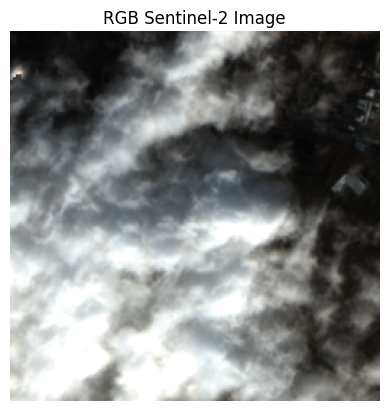

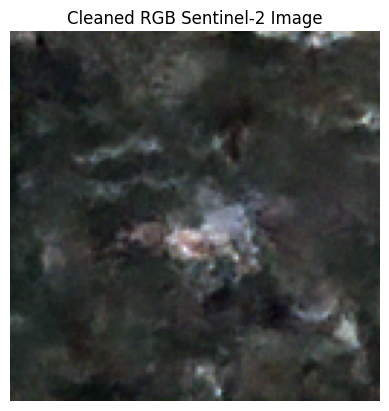

In [52]:
# Run pipeline on one patch

target = f'{folder}/patch_31624.tif'
img = get_example_image(target, plot=False)

image_13, cleaned_13, x0_norm, x0_rescaled = run_cloud_removal_on_s2_patch(
    path=target,
    cloud_encoder=cloud_encoder,
    denoiser=denoiser,
    forwarder=forwarder,
    device=device,
    num_steps=750,
    T=3,
    plot=True,
)

# Visualize cleaned RGB
r = cleaned_13[3].numpy()
g = cleaned_13[2].numpy()
b = cleaned_13[1].numpy()
plt.imshow(np.stack([r, g, b], axis=-1))
plt.title("Cleaned RGB Sentinel-2 Image")
plt.axis("off")
plt.show()

# Prepare for SatCLIP (add batch dim)



In [53]:
image_in = image_13
print(image_in.shape)
cleaned = cleaned_13.to(device)  # (1,13,H,W)
print(cleaned.shape)
print(target)

torch.Size([13, 128, 128])
torch.Size([13, 128, 128])
satclip\data_10.tar\data_10/patch_31624.tif


In [54]:
#True
img_emb = model.visual(image_in.unsqueeze(0).to(device))
#Find row in control_embs that is closest to loc_emb by cosine similarity
cosine_sim = cosine_similarity(img_emb.cpu().detach().numpy(), control_embs.cpu().detach().numpy())
#Get index of control location corresponding to embedding with highest cosine similarity to image embedding
closest = np.argmax(cosine_sim)
print(control_lons[closest], control_lats[closest])

90.11465233619784 28.861576464229756


In [55]:
#Pred
img_emb_cleaned = model.visual(cleaned.unsqueeze(0).to(device))
#Find row in control_embs that is closest to loc_emb by cosine similarity
cosine_sim_cleaned = cosine_similarity(img_emb_cleaned.cpu().detach().numpy(), control_embs.cpu().detach().numpy())
#Get index of control location corresponding to embedding with highest cosine similarity to image embedding
closest_cleaned = np.argmax(cosine_sim_cleaned)
print(control_lons[closest_cleaned], control_lats[closest_cleaned])

-26.9004802936725 -26.893624727212732
